Если есть проблемы с запуском ноутбука, запустите инференс в том же ноутбуке что и тренировка (отдельный файл)

Ссылка на файл с весами моделей: https://drive.google.com/drive/folders/1z-8_IXJCk9VU0p58EbrRCWHPKRHzOTQg?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install Ninja

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-528pddsh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-528pddsh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 21.04 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [ ]:
cd stylegan2-pytorch/

/content/stylegan2-pytorch


In [ ]:
torch.manual_seed(345)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from model import Generator
latent_dim = 512

generator_frozen = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
state_dict = torch.load('/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt', map_location=device)
generator_frozen.load_state_dict(state_dict['g_ema'])
generator_frozen.eval()

generator_train = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
generator_train.load_state_dict(generator_frozen.state_dict())
generator_train.train()

print("Генераторы StyleGAN2 загружены.")

In [ ]:
!git clone https://github.com/richzhang/PerceptualSimilarity.git lpips
%cd lpips
!pip install -e .

Cloning into 'lpips'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 8.76 MiB | 13.00 MiB/s, done.
Resolving deltas: 100% (476/476), done.
/content/stylegan2-pytorch/lpips/lpips
Obtaining file:///content/stylegan2-pytorch/lpips/lpips
  Preparing metadata (setup.py) ... done
  Attempting uninstall: lpips
    Found existing installation: lpips 0.1.4
    Uninstalling lpips-0.1.4:
      Successfully uninstalled lpips-0.1.4
  Running setup.py develop for lpips


In [ ]:
import lpips
def edit_generated_image(generator, num_steps=300):
    z = torch.randn(1, latent_dim, device=device)
    with torch.no_grad():
        z = torch.randn(1, latent_dim, device=device)
        img_source, _ = generator_frozen([z], input_is_latent=False)

    z = z.clone().detach().requires_grad_(True)

    with torch.no_grad():
        final_img, _ = generator([z], input_is_latent=False)

    return img_source, final_img

def edit_real_image(z, image_path, inversion_steps=500, info_for_n_member=100):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.CenterCrop(1024),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    img_source = transform(image).unsqueeze(0).to(device)

    z = torch.randn(1, 512, device=device).requires_grad_(True)
    optimizer = optim.Adam([z], lr=0.01)

    mse_loss = nn.MSELoss()
    loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)
    loss_fn_vgg.eval()
    model_path = "/content/stylegan2-pytorch/model_ir_se50.pth"
    id_loss = IDLoss(model_path, device)
    id_loss.eval()

    for step in range(inversion_steps):
        img_recon, _ = generator_frozen([z], input_is_latent=False)

        mse = mse_loss(img_recon, img_source) * 0.8
        lpips_val = loss_fn_vgg(img_recon, img_source).mean() * 0.5
        id_l = id_loss(img_recon, img_source)

        loss = mse + lpips_val + id_l

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % info_for_n_member == 0:
            print(f"Inversion step {step}, Loss: {loss.item():.4f}")

    with torch.no_grad():
        reconstructed_img, _ = generator_frozen([z], input_is_latent=False)
        reconstructed_img = reconstructed_img[0].permute(1, 2, 0).cpu().numpy()
        reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min())

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow((img_source[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

    paths = [
        '/content/stylegan2-pytorch/generator_a_zombie_face.pt',
        '/content/stylegan2-pytorch/generator_a_fantasy_elf.pt',
        '/content/stylegan2-pytorch/generator_a_jocker_face.pt',
        '/content/stylegan2-pytorch/generator_a_pixar_3D_render.pt',
        '/content/stylegan2-pytorch/generator_a_watercolor_painting.pt',
        '/content/stylegan2-pytorch/generator_an_anime_character.pt'
    ]

    results = []

    for path in paths:
        generator = Generator(size=1024, style_dim=512, n_mlp=8).to(device)
        state_dict = torch.load(path, map_location=device)
        generator.load_state_dict(state_dict)
        generator.eval()

        with torch.no_grad():
            stylized_img, _ = generator([z], input_is_latent=False)
            stylized_img_np = stylized_img[0].permute(1, 2, 0).cpu().numpy()
            stylized_img_np = (stylized_img_np - stylized_img_np.min()) / (stylized_img_np.max() - stylized_img_np.min())

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow((img_source[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5))
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(stylized_img_np)
            plt.title(path.split('/')[-1].replace('generator_', '').replace('.pt', ''))
            plt.axis('off')
            plt.show()

            results.append((path, stylized_img))

    return img_source, results

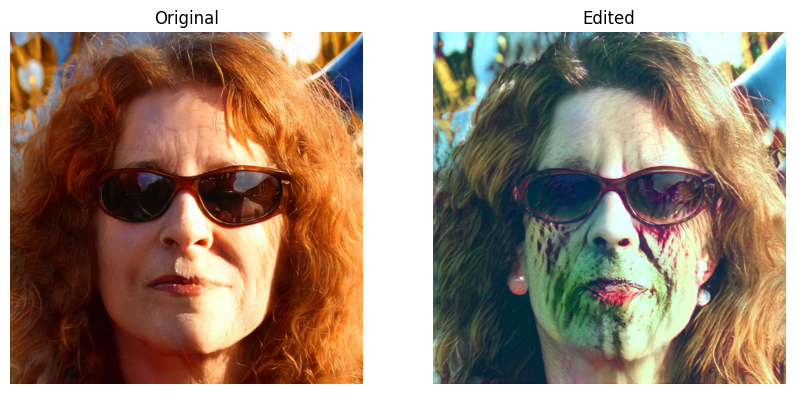

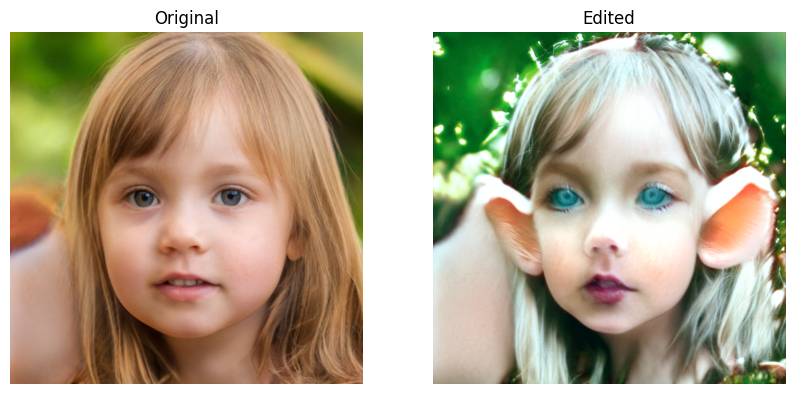

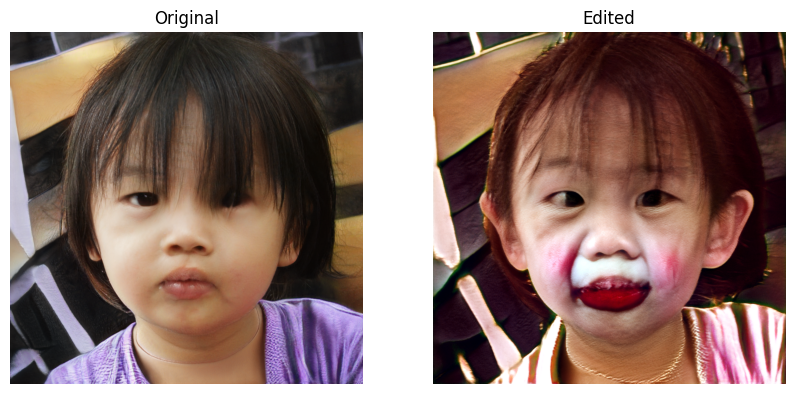

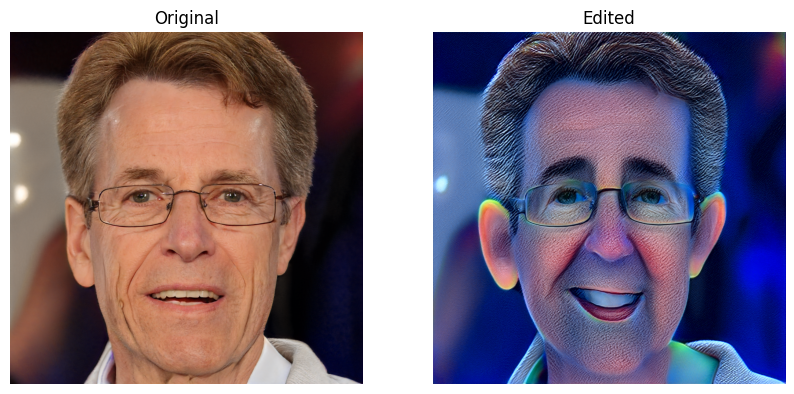

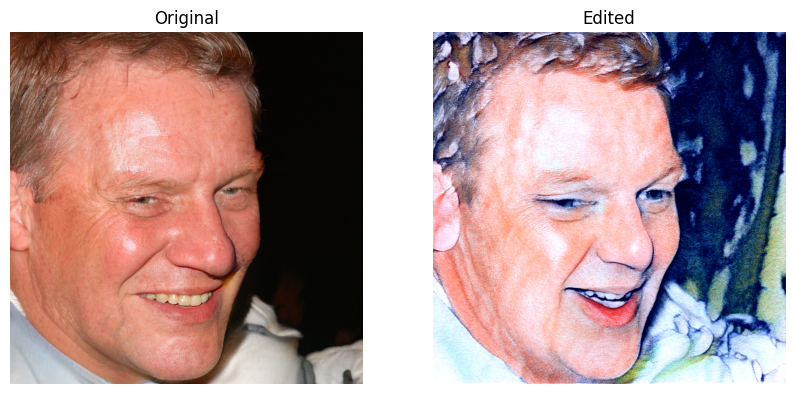

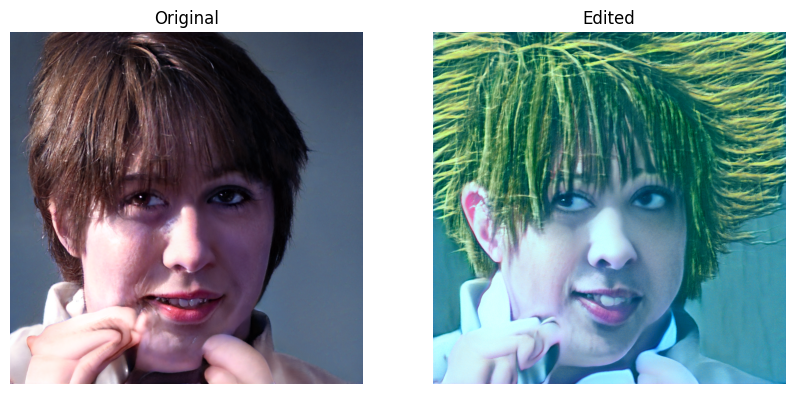

In [ ]:
paths = ['/content/stylegan2-pytorch/generator_a_zombie_face.pt', '/content/stylegan2-pytorch/generator_a_fantasy_elf.pt',
         '/content/stylegan2-pytorch/generator_a_jocker_face.pt', '/content/stylegan2-pytorch/generator_a_pixar_3D_render.pt',
         '/content/stylegan2-pytorch/generator_a_watercolor_painting.pt', '/content/stylegan2-pytorch/generator_an_anime_character.pt']
for path in paths:
  generator_train = Generator(size=1024, style_dim=512, n_mlp=8).to(device)
  state_dict = torch.load(path, map_location=device)
  generator_train.load_state_dict(state_dict)
  generator_train.eval()

  source_img, edited_img = edit_generated_image(
      generator_train
  )

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow((source_img[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5))
  plt.title("Original")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow((edited_img[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5))
  plt.title("Edited")
  plt.axis('off')
  plt.show()

In [ ]:
with torch.no_grad():
    z = torch.randn(1, latent_dim, device=device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /content/stylegan2-pytorch/lpips/lpips/lpips/weights/v0.1/vgg.pth
Loading ResNet ArcFace


/content/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu124. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


Inversion step 0, Loss: 1.9140
Inversion step 250, Loss: 1.2341
Inversion step 500, Loss: 1.2536
Inversion step 750, Loss: 1.2130
Inversion step 1000, Loss: 1.1061
Inversion step 1250, Loss: 1.0073


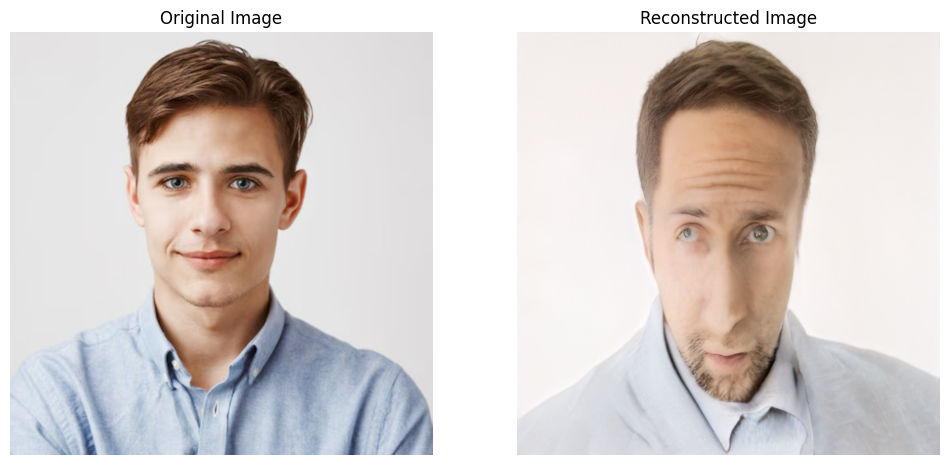

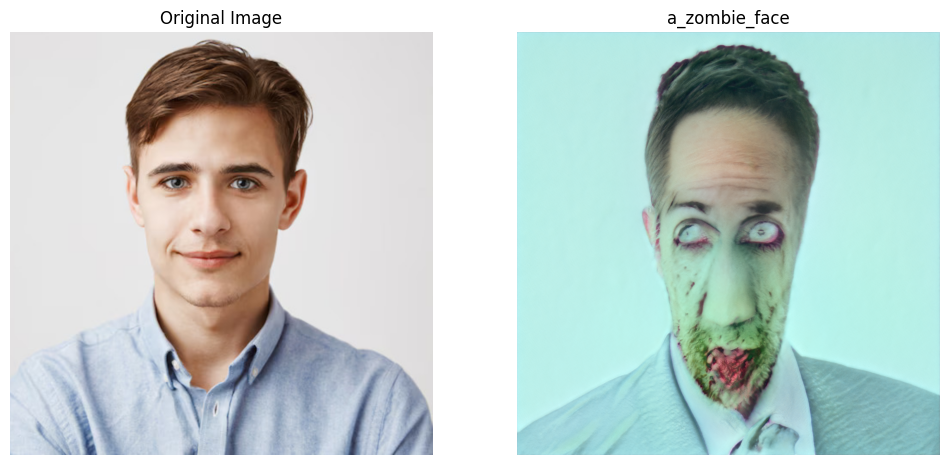

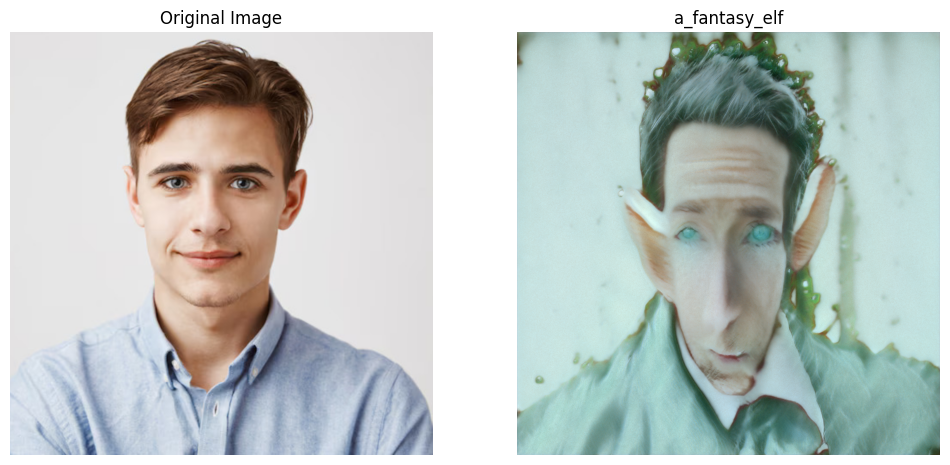

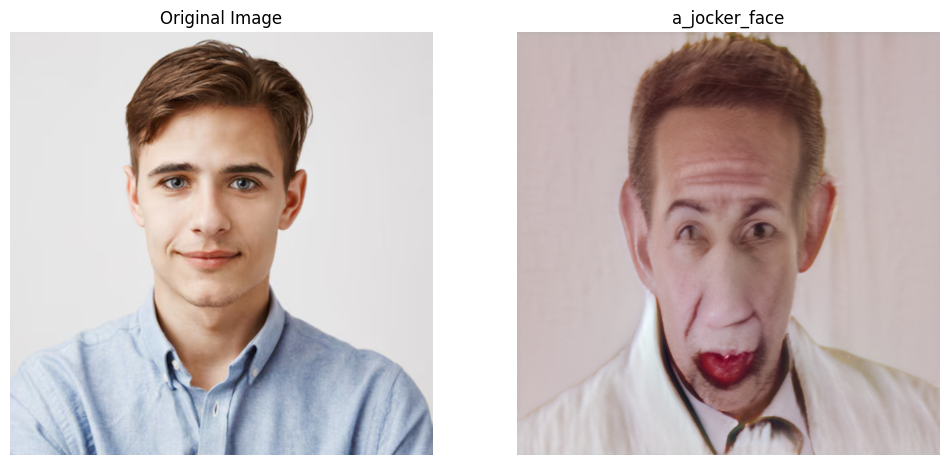

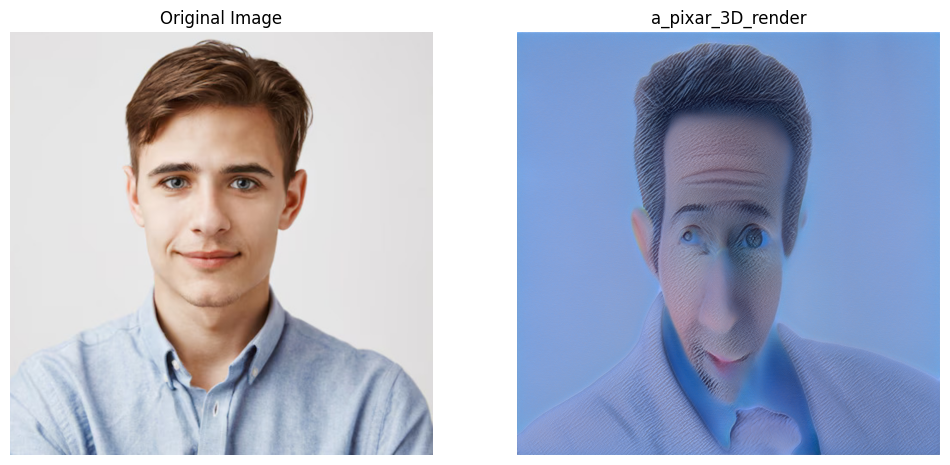

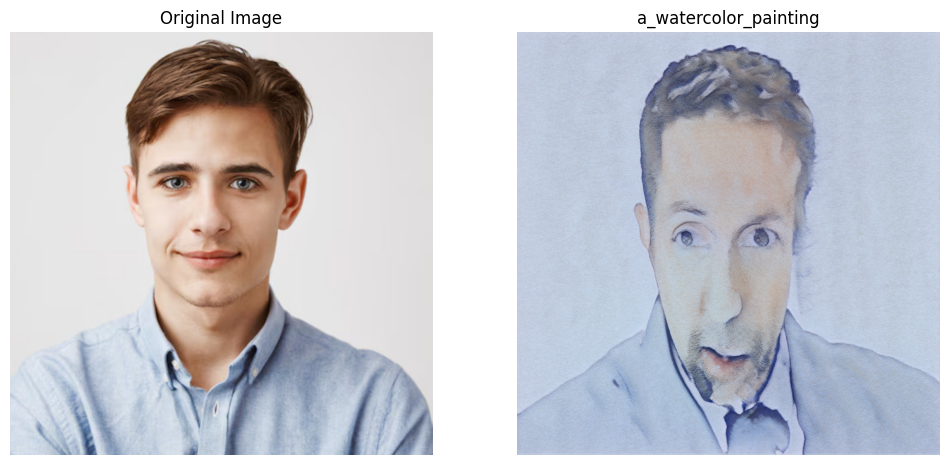

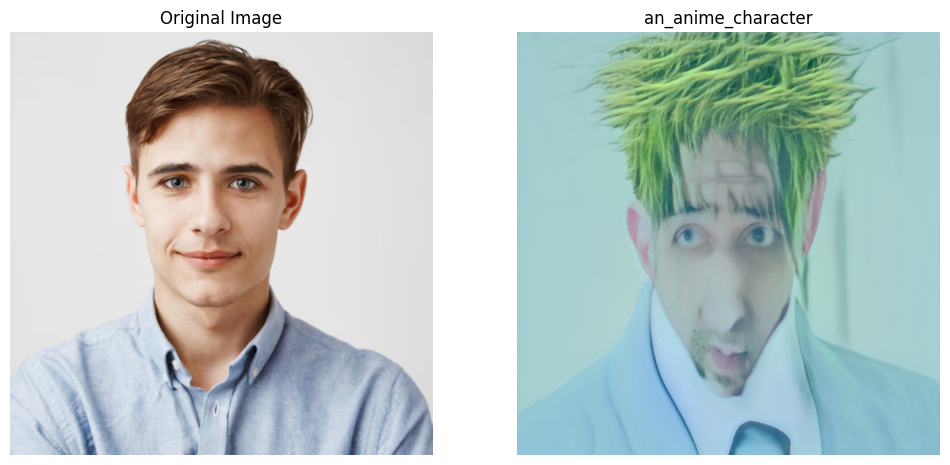

In [ ]:
source_img, inverted_img = edit_real_image(
      image_path="/content/portrait-handsome-young-man-closeup_176420-15568.jpg.jpg",
      inversion_steps=1500,
      info_for_n_member=250
  )